In [34]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [35]:
import zipfile
from PIL import Image
import PIL
import pytesseract
import cv2 as cv
import numpy as np

# loading the face detection classifier
face_cascade = cv.CascadeClassifier('readonly/haarcascade_frontalface_default.xml')

In [36]:
# Store all information extracted from the images in the zip file to a dictionary
def extract_news_info(zip_path):
    news_info = {}
    with zipfile.ZipFile(zip_path) as zip_file:
        fnames = zip_file.namelist()
        for name in fnames:
            with zip_file.open(name) as file:
                # Decode cv image before opening the file using PIL to prevent returning None Type
                cv_image = cv.imdecode(np.frombuffer(file.read(), np.uint8), 1)
                # Get bounds of detected faces from grayscale cv image
                gray = cv.cvtColor(cv_image, cv.COLOR_BGR2GRAY)
                faces = face_cascade.detectMultiScale(gray, 1.3, 5)

                # Open image using PIL
                pil_image = Image.open(file)
                # Get text from the PIL image
                text = pytesseract.image_to_string(pil_image)

                # Store to PIL image, text, and bounds of faces to news_info
                news_info[name] = [pil_image, text, faces]

    return news_info

In [37]:
# Accepts a string arg that matches information to the returned news info of extract_news_info func
def search_images(name, info):
    keys = list(info.keys())
    for key in keys:
        if name in info[key][1]:  # get text info with index 1
            image = info[key][0]  # image
            faces = info[key][2]  # bounding boxes

            # Check for possible detected faces
            if len(faces) > 0:
                # Create contact sheet for each cropped face
                contact_sheet_w = 100
                contact_sheet_h = 100
                rows = int(np.ceil(len(faces) / 5))
                contact_sheet = PIL.Image.new(image.mode, (contact_sheet_w * 5, contact_sheet_h * rows))

                # Crop each face using bounding box and paste each cropped image to contact sheet
                r = 0  # row index
                c = 0  # col index
                for x, y, w, h in faces:
                    crop = image.crop((x, y, x+w, y+h))
                    if crop.width > contact_sheet_w:
                        crop = crop.resize((100, 100))
                        contact_sheet.paste(crop, (r, c))

                    else:
                        contact_sheet.paste(crop, (r, c))

                    if crop.width + r == contact_sheet.width:
                        r = 0
                        c += crop.height

                    else:
                        r += contact_sheet_w

                # Resize contact sheet
                contact_sheet = contact_sheet.resize((int(contact_sheet.width), int(contact_sheet.height)))
                # Print and display results
                print("Results found in file {}".format(key))
                display(contact_sheet)

            # If name in the extracted text but no detect faces
            else:
                print("Results found in file {}".format(key))
                print("But there were no faces in that file!")

In [39]:
# Load the cascade classifier
face_cascade = cv.CascadeClassifier(cv.data.haarcascades + 'haarcascade_frontalface_default.xml')

# Check if the cascade classifier is loaded successfully
if face_cascade.empty():
    print("Error: Cascade classifier not loaded!")


In [40]:
small_test = extract_news_info("/content/drive/MyDrive/File/small_img.zip")


Results found in file a-0.png


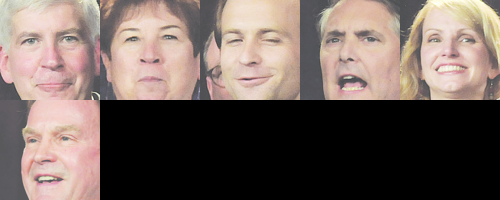

Results found in file a-3.png


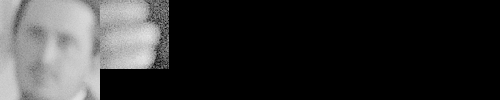

In [41]:
# Test for small test data
search_images("Christopher", small_test)

In [42]:
# News info for bigger test data
big_test = extract_news_info("/content/drive/MyDrive/File/images.zip")

Results found in file a-0.png


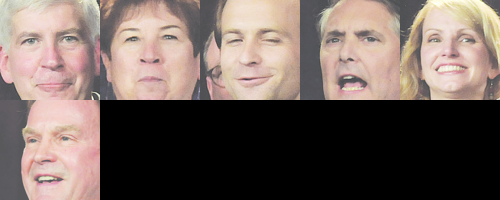

Results found in file a-1.png


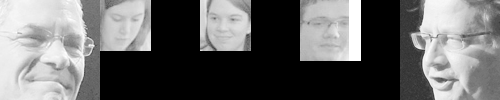

Results found in file a-10.png
But there were no faces in that file!
Results found in file a-13.png


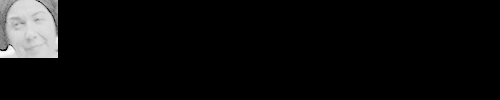

Results found in file a-2.png


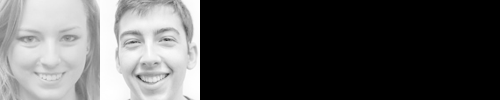

Results found in file a-3.png


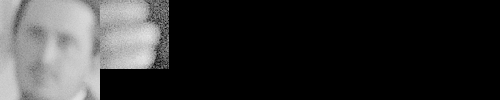

Results found in file a-8.png
But there were no faces in that file!


In [43]:
# Test for bigger test data
search_images("Mark", big_test)